In [13]:
import re
import json
import altair as alt
import pandas as pd
import numpy as np

from collections import defaultdict
from copy import deepcopy
from pathlib import Path

alt.__version__
#!pip install selenium # to save as SVG plots
UMCCR_PALETTE=["#A1C9F4", "#FFB482"]

## Curated telomeric coordinates, multimapped reads found within BEDfile limits

### 10X & Truseq datasets

In [14]:
chr_array = ['chr'+str(x) for x in range(1,23)]
chr_array.append('chrX')
chr_array.append('chrY')
chr_array.append('chrM')

chr_cat = pd.Series(chr_array, dtype="category")
chr_num = [x.replace('chr', '') for x in chr_array]

In [3]:
def rewrite_chrs(df, col):
    ''' Rewrite chromosome numbers, while we wait for axis ordering on altair-viz
    '''
    repl_chr = lambda m: m.group(1)
    
    df_res = deepcopy(df)
    
    df_res[col] = df_res[col].str.replace(r"chr(\d+)", repl_chr)
    df_res[col] = df_res[col].str.replace(r"chrX", "23")
    df_res[col] = df_res[col].str.replace(r"chrY", "24")
    df_res[col] = df_res[col].str.replace(r"chrM", "25")
    
    return df_res


In [4]:
colo829bl_10x = pd.read_csv("../data/processed/manual_telomere_coords/COLO829BL-10X-hg38.hist.csv", dtype={"mmap_count": np.int})
colo829t_10x = pd.read_csv("../data/processed/manual_telomere_coords/COLO829T-10X-hg38.hist.csv", dtype={"mmap_count": np.int})
colo829bl = pd.read_csv("../data/processed/manual_telomere_coords/COLO829BL-hg38.hist.csv", dtype={"mmap_count": np.int})
colo829t = pd.read_csv("../data/processed/manual_telomere_coords/COLO829T-hg38.hist.csv", dtype={"mmap_count": np.int})

colo829bl_10x['technology'] = '10X'
colo829bl_10x['sample'] = 'colo829bl_10x'
colo829t_10x['technology'] = '10X'
colo829t_10x['sample'] = 'colo829t_10x'

colo829t['technology'] = 'Truseq'
colo829t['sample'] = 'colo829t'
colo829bl['technology'] = 'Truseq'
colo829bl['sample'] = 'colo829bl'

In [5]:
colo829bl["chromosome"] = pd.Categorical(colo829bl["chromosome"], chr_array)

In [6]:
datasets = [colo829bl_10x, colo829t_10x, colo829bl, colo829t]
datasets_excluded_chroms = []

for ds in datasets:
    ds = ds[ds['chromosome'] != 'chr5']
    ds = ds[ds['chromosome'] != 'chr1']
    ds = ds[ds['chromosome'] != 'chrX']
    ds = ds[ds['chromosome'] != 'chr22']
    ds = ds[ds['chromosome'] != 'chrY']
    ds = ds[ds['chromosome'] != 'chr12']
    ds = ds[ds['chromosome'] != 'chr18']
    ds = ds[ds['chromosome'] != 'chr10']

    datasets_excluded_chroms.append(ds)

In [7]:
#dataset_curated = pd.concat(datasets_excluded_chroms, ignore_index=True)
dataset_curated = pd.concat(datasets, ignore_index=True)
dataset_curated.reset_index()

dataset_curated["log"] = dataset_curated["mmap_count"].apply(np.log)

dataset_curated["chromosome"] = pd.Categorical(dataset_curated["chromosome"], chr_array)
dataset_curated = dataset_curated.sort_values("chromosome")

repl = lambda m: m.group(1)

dataset_curated['chromosome'] = dataset_curated['chromosome'].str.replace(r"chr(\d+)", repl)
dataset_curated['chromosome'] = dataset_curated['chromosome'].str.replace(r"chrX", "23")
dataset_curated['chromosome'] = dataset_curated['chromosome'].str.replace(r"chrY", "24")
dataset_curated['chromosome'] = dataset_curated['chromosome'].str.replace(r"chrM", "25")

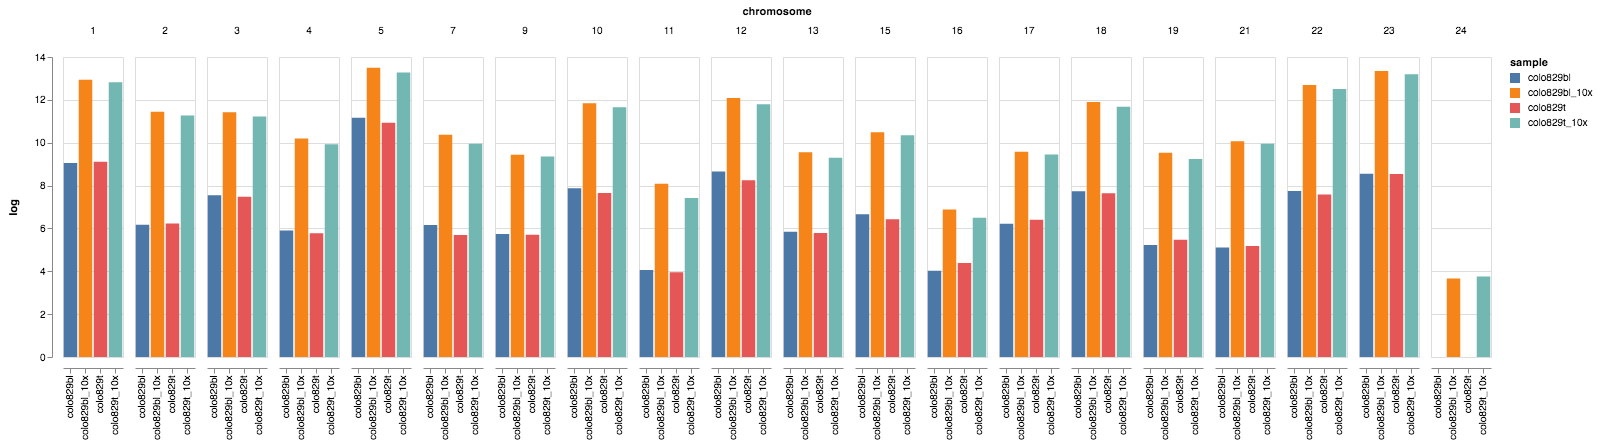

In [8]:

sample_chart = alt.Chart(dataset_curated).mark_bar().encode(
        alt.X('sample:N', scale=alt.Scale(rangeStep=15), axis=alt.Axis(title='')),
        alt.Y('mmap_count:Q', axis=alt.Axis(title='Mapped reads')),
        color = alt.Color('sample:N'), #scale=alt.Scale(range["#EA98D2", "#659CCA", "#EA98D2", "#EA98D2", "#EA98D2"])),
        column = 'chromosome:N'
)

tech_chart = alt.Chart(dataset_curated).mark_bar().encode(
        alt.X('technology:N', scale=alt.Scale(rangeStep=15), axis=alt.Axis(title='')),
        alt.Y('mmap_count:Q', axis=alt.Axis(title='Mapped reads')),
        color = alt.Color('technology:N'), #scale=alt.Scale(range["#EA98D2", "#659CCA", "#EA98D2", "#EA98D2", "#EA98D2"])),
        column = 'chromosome:N'
)

logplot = alt.Chart(dataset_curated).mark_bar().encode(
        alt.X('sample:N', scale=alt.Scale(rangeStep=15), axis=alt.Axis(title='')),
        y = 'log:Q',
        color = alt.Color('sample:N'), #scale=alt.Scale(range["#EA98D2", "#659CCA", "#EA98D2", "#EA98D2", "#EA98D2"])),
        #column = 'chromosome:N'
        column = alt.Column('chromosome:Q')
)


#sample_chart
#| tech_chart | logplot
#sample_chart | tech_chart | logplot
logplot

## Absolute mapped reads for the whole datasets (samtools idxstats)

https://standage.github.io/an-idiots-guide-to-loading-reads-from-a-bam-file.html

### 10X

In [9]:
colo829bl_10x_baseline = pd.read_csv("../data/processed/colo829_baseline/COLO829BL-10X-baseline-idxstats-hg38.hist.csv")
colo829t_10x_baseline = pd.read_csv("../data/processed/colo829_baseline/COLO829T-10X-baseline-idxstats-hg38.hist.csv")

colo829bl_10x_baseline['technology'] = '10X'
colo829bl_10x_baseline['sample'] = 'colo829bl_10x'
colo829t_10x_baseline['technology'] = '10X'
colo829t_10x_baseline['sample'] = 'colo829t_10x'

### Truseq

In [10]:
colo829bl_baseline = pd.read_csv("../data/processed/colo829_baseline/COLO829BL-baseline-idxstats-hg38.hist.csv")
colo829t_baseline = pd.read_csv("../data/processed/colo829_baseline/COLO829T-baseline-idxstats-hg38.hist.csv")

colo829t_baseline['technology'] = 'Truseq'
colo829t_baseline['sample'] = 'colo829t'
colo829bl_baseline['technology'] = 'Truseq'
colo829bl_baseline['sample'] = 'colo829bl'

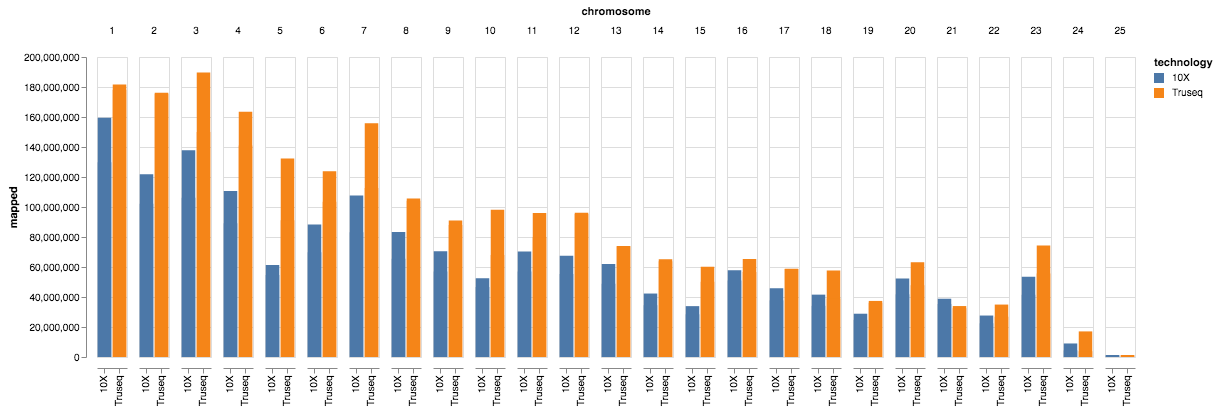

In [11]:
datasets_baseline = [colo829bl_10x_baseline, colo829t_10x_baseline, colo829bl_baseline, colo829t_baseline]
baseline_dataset = pd.concat(datasets_baseline, ignore_index=True)
baseline_dataset["log"] = baseline_dataset["mapped"].apply(np.log)

baseline_dataset = rewrite_chrs(baseline_dataset, 'chromosome')

sample_chart = alt.Chart(baseline_dataset).mark_bar().encode(
        alt.X('sample:N', scale=alt.Scale(rangeStep=15), axis=alt.Axis(title='')),
        alt.Y('mapped:Q', axis=alt.Axis(title='Mapped reads')),
        color = alt.Color('sample:N'), #scale=alt.Scale(range["#EA98D2", "#659CCA", "#EA98D2", "#EA98D2", "#EA98D2"])),
        column = 'chromosome:N'
)

tech_chart = alt.Chart(baseline_dataset).mark_bar().encode(
        alt.X('technology:N', scale=alt.Scale(rangeStep=15), axis=alt.Axis(title='')),
        alt.Y('mapped:Q', axis=alt.Axis(title='Mapped reads')),
        color = alt.Color('technology:N'), #scale=alt.Scale(range["#EA98D2", "#659CCA", "#EA98D2", "#EA98D2", "#EA98D2"])),
        column = 'chromosome:N'
)


logplot = alt.Chart(baseline_dataset).mark_bar().encode(
        alt.X('technology:N', scale=alt.Scale(rangeStep=15), axis=alt.Axis(title='')),
        y = 'mapped:Q',
        color = alt.Color('technology:N'), #scale=alt.Scale(range["#EA98D2", "#659CCA", "#EA98D2", "#EA98D2", "#EA98D2"])),
        #column = 'chromosome:N'
        column = alt.Column('chromosome:Q')
)


#sample_chart | tech_chart | logplot
#sample_chart & tech_chart | logplot
#sample_chart
#logplot.properties(width=200, height=200)
logplot

## Absolute mapped reads for the telomeric curated coordinates

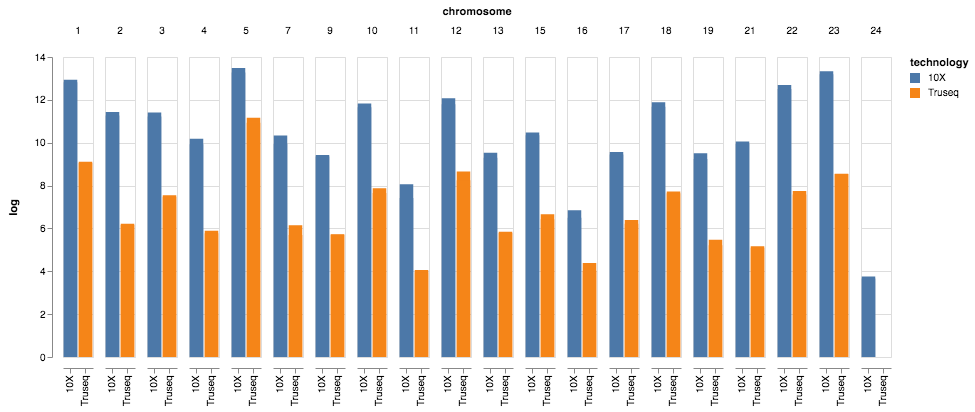

In [12]:
colo829bl_10x = pd.read_csv("../data/processed/manual_telomere_coords/COLO829BL-10X-sliced-idxstats-hg38.hist.csv")
colo829t_10x = pd.read_csv("../data/processed/manual_telomere_coords/COLO829T-10X-sliced-idxstats-hg38.hist.csv")
colo829bl = pd.read_csv("../data/processed/manual_telomere_coords/COLO829BL-sliced-idxstats-hg38.hist.csv")
colo829t = pd.read_csv("../data/processed/manual_telomere_coords/COLO829T-sliced-idxstats-hg38.hist.csv")

colo829bl_10x['technology'] = '10X'
colo829bl_10x['sample'] = 'colo829bl_10x'
colo829t_10x['technology'] = '10X'
colo829t_10x['sample'] = 'colo829t_10x'

colo829t['technology'] = 'Truseq'
colo829t['sample'] = 'colo829t'
colo829bl['technology'] = 'Truseq'
colo829bl['sample'] = 'colo829bl'

datasets = [colo829bl_10x, colo829t_10x, colo829bl, colo829t]

datasets = pd.concat(datasets, ignore_index=True)
datasets["log"] = datasets["mapped"].apply(np.log)

repl = lambda m: m.group(1)

datasets['chromosome'] = datasets['chromosome'].str.replace(r"chr(\d+)", repl)
datasets['chromosome'] = datasets['chromosome'].str.replace(r"chrX", "23")
datasets['chromosome'] = datasets['chromosome'].str.replace(r"chrY", "24")
datasets['chromosome'] = datasets['chromosome'].str.replace(r"chrM", "25")


sample_chart = alt.Chart(datasets).mark_bar().encode(
        x = 'mapped:Q',
        y = 'chromosome:N',
        color = 'sample:N'
)

logplot = alt.Chart(datasets).mark_bar().encode(
        alt.X('technology:N', scale=alt.Scale(rangeStep=15), axis=alt.Axis(title='')),
        y = 'log:Q',
        color = alt.Color('technology:N'), #scale=alt.Scale(range["#EA98D2", "#659CCA", "#EA98D2", "#EA98D2", "#EA98D2"])),
        column = alt.Column('chromosome:Q')
)

#sample_chart | tech_chart | logplot
logplot

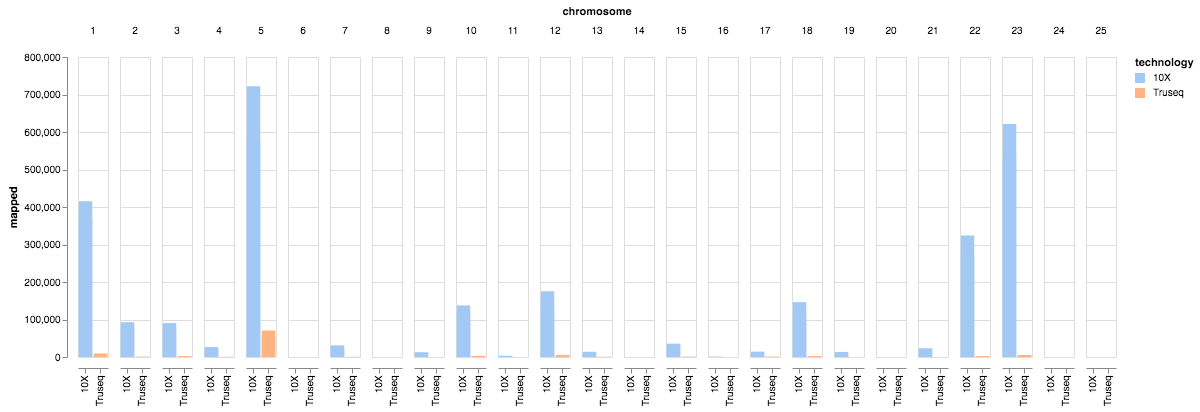

In [13]:
tech_chart = alt.Chart(datasets).mark_bar().encode(
        alt.X('technology:N', scale=alt.Scale(rangeStep=15), axis=alt.Axis(title='')),
        y = 'mapped:Q',
        color = alt.Color('technology:N', scale=alt.Scale(range=UMCCR_PALETTE)),
        column = alt.Column('chromosome:Q')
)

tech_chart.save('10x_telomeres_mapped_reads.svg')
datasets.to_csv('10x_telomeres_mapped_reads.csv')
tech_chart

## UNmapped reads for the telomeric curated coordinates

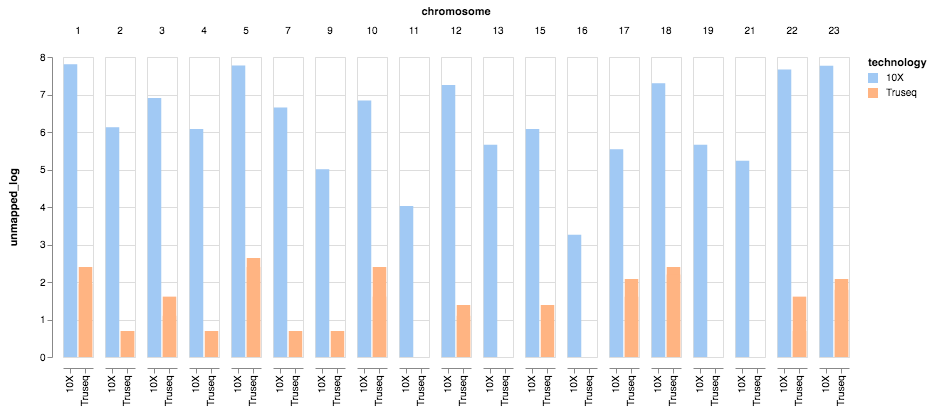

In [14]:
datasets["unmapped_log"] = datasets["unmapped"].apply(np.log)

repl = lambda m: m.group(1)

logplot = alt.Chart(datasets).mark_bar().encode(
        alt.X('technology:N', scale=alt.Scale(rangeStep=15), axis=alt.Axis(title='')),
        y = 'unmapped_log:Q',
        color = alt.Color('technology:N', scale=alt.Scale(range=UMCCR_PALETTE)),
        #column = 'chromosome:N'
        column = alt.Column('chromosome:Q')
)

#sample_chart | tech_chart | logplot
logplot.save('10x_telomeres_unmapped_reads.svg')
logplot

### Absolute

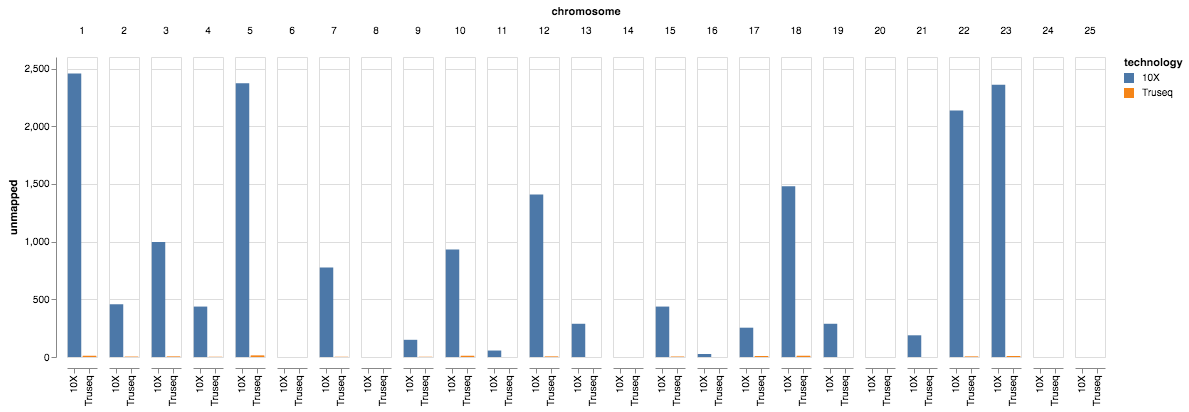

In [15]:
tech_chart_unmapped = alt.Chart(datasets).mark_bar().encode(
        alt.X('technology:N', scale=alt.Scale(rangeStep=15), axis=alt.Axis(title='')),
        y = 'unmapped:Q',
        color = alt.Color('technology:N'),
        column = alt.Column('chromosome:Q')
)

tech_chart_unmapped

# Flagstats

In [16]:
# Thanks @ewels :)
# https://github.com/ewels/MultiQC/blob/master/multiqc/modules/samtools/flagstat.py

# And good summary, using the samtools flagstat source: https://www.biostars.org/p/12475/

# flagstat has one thing per line, documented here (search for flagstat):
# http://www.htslib.org/doc/samtools.html

flagstat_regexes = {
    'total':         r"(\d+) \+ (\d+) in total \(QC-passed reads \+ QC-failed reads\)",
    'secondary':     r"(\d+) \+ (\d+) secondary",
    'supplementary': r"(\d+) \+ (\d+) supplementary",
    'duplicates':    r"(\d+) \+ (\d+) duplicates",
    'mapped':        r"(\d+) \+ (\d+) mapped \((.+):(.+)\)",
    'paired in sequencing': r"(\d+) \+ (\d+) paired in sequencing",
    'read1':         r"(\d+) \+ (\d+) read1",
    'read2':         r"(\d+) \+ (\d+) read2",
    'properly paired': r"(\d+) \+ (\d+) properly paired \((.+):(.+)\)",
    'with itself and mate mapped': r"(\d+) \+ (\d+) with itself and mate mapped",
    'singletons':    r"(\d+) \+ (\d+) singletons \((.+):(.+)\)",
    'with mate mapped to a different chr': r"(\d+) \+ (\d+) with mate mapped to a different chr",
    'with mate mapped to a different chr (mapQ >= 5)': r"(\d+) \+ (\d+) with mate mapped to a different chr \(mapQ>=5\)",
}

def parse_single_report(file_obj):
    """
    Take a filename, parse the data assuming it's a flagstat file
    Returns a dictionary {'lineName_pass' : value, 'lineName_fail' : value}
    """
    parsed_data = {}

    re_groups = ['passed', 'failed', 'passed_pct', 'failed_pct']
    for k, r in flagstat_regexes.items():
        r_search = re.search(r, file_obj, re.MULTILINE)
        if r_search:
            for i,j in enumerate(re_groups):
                try:
                    key = "{}_{}".format(k, j)
                    val = r_search.group(i+1).strip('% ')
                    parsed_data[key] = float(val) if ('.' in val) else int(val)
                except IndexError:
                    pass # Not all regexes have percentages
                except ValueError:
                    parsed_data[key] = float('nan')
    # Work out the total read count
    try:
        parsed_data['flagstat_total'] = parsed_data['total_passed'] + parsed_data['total_failed']
    except KeyError:
        pass
    return parsed_data

In [17]:
files = Path('../data/processed/manual_telomere_coords/').glob('*-flagstat-*.txt')
json_flagstats = defaultdict(dict)

for f in files:
    with open(f, 'r') as flagstat_out:
        fname = str.lower(f.name.replace('-sliced-flagstat-hg38.hist.txt', '')).replace('-', '_')
        json_flagstats[fname] = parse_single_report(flagstat_out.read())
        pd_flagstats = pd.DataFrame.from_dict(json_flagstats)

pd_flagstats

,colo829bl,colo829bl_10x,colo829t,colo829t_10x
duplicates_failed,0.00,0.00,0.00,0.00
duplicates_passed,9796.00,177383.00,6803.00,176861.00
flagstat_total,103029.00,2917658.00,85415.00,2419177.00
mapped_failed,0.00,0.00,0.00,0.00
mapped_failed_pct,NaN,NaN,NaN,NaN
mapped_passed,102946.00,2900160.00,85350.00,2419177.00
mapped_passed_pct,99.92,99.40,99.92,100.00
paired in sequencing_failed,0.00,0.00,0.00,0.00
paired in sequencing_passed,102766.00,2891015.00,85102.00,2419177.00
properly paired_failed,0.00,0.00,0.00,0.00


In [18]:
pd_flagstats.columns, set(datasets['sample'])

(Index(['colo829bl', 'colo829bl_10x', 'colo829t', 'colo829t_10x'], dtype='object'),
 {'colo829bl', 'colo829bl_10x', 'colo829t', 'colo829t_10x'})

## Mapped pct reads (reads_mapped_chrom / flagstats.total_passed)

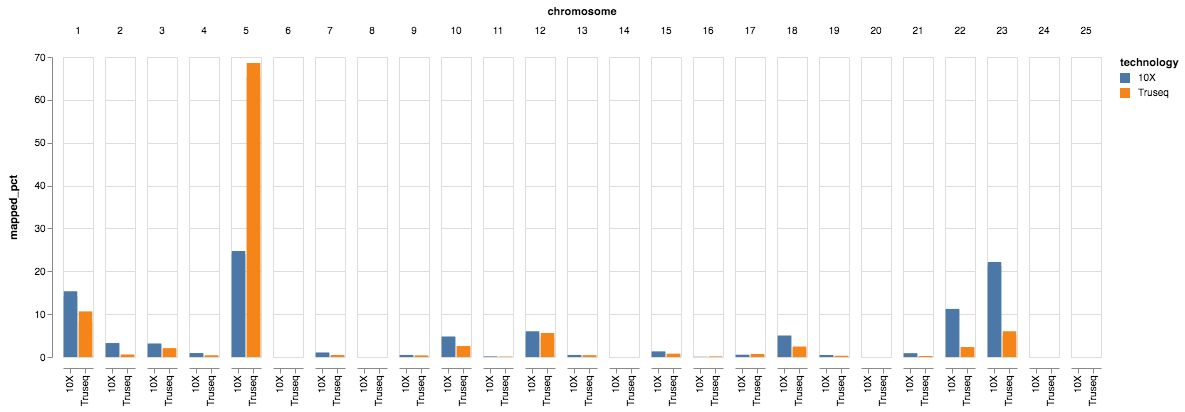

In [19]:
for sample in pd_flagstats.columns:
    datasets.loc[datasets['sample'] == sample, "mapped_pct"] = (datasets[datasets['sample'] == sample]['mapped'] / pd_flagstats[sample]['total_passed']) * 100

mapped_pct = alt.Chart(datasets).mark_bar().encode(
        alt.X('technology:N', scale=alt.Scale(rangeStep=15), axis=alt.Axis(title='')),
        y = 'mapped_pct:Q',
        color = alt.Color('technology:N'),
        column = alt.Column('chromosome:Q')
)

mapped_pct

## Bedfile lengths per chrom

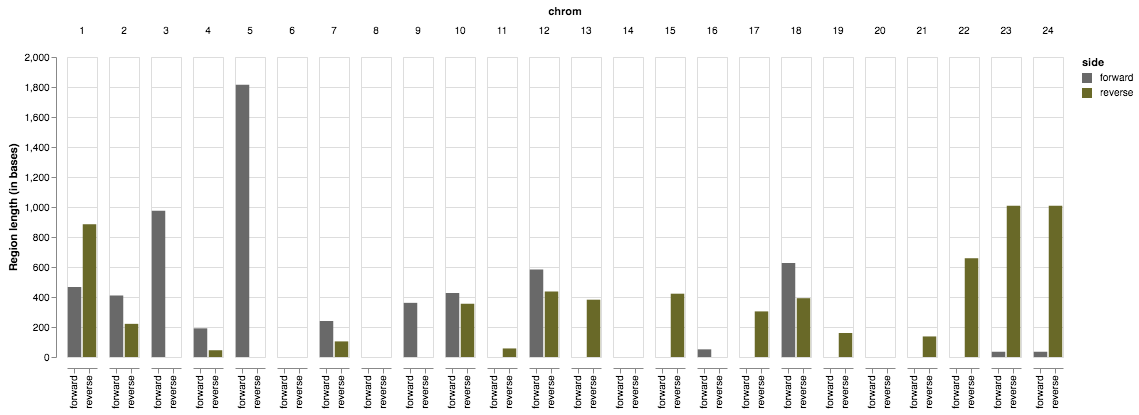

In [20]:
telobed = pd.read_csv('../data/processed/hg38_igv_manual_by_side.bed', sep='\t', names=['chrom', 'start', 'end', 'side'])

for chrom in telobed['chrom']:
    if "_f" in chrom:
        telobed.loc[telobed['chrom'] == chrom, 'side'] = "forward"
    elif "_r":
        telobed.loc[telobed['chrom'] == chrom, 'side'] = "reverse"

# Cleanup after enriching for sides
telobed['chrom'] = telobed['chrom'].str.replace('_f', '')
telobed['chrom'] = telobed['chrom'].str.replace('_r', '')

telobed['telomere_length'] = telobed['end'] - telobed['start']

telobed = rewrite_chrs(telobed, 'chrom')
telobed.sort_values(by=['chrom'])

telobedplot = alt.Chart(telobed).mark_bar().encode(
        alt.X('side:N', scale=alt.Scale(rangeStep=15), axis=alt.Axis(title='')),
        alt.Y('telomere_length:Q', axis=alt.Axis(title='Region length (in bases)')),
        color = alt.Color('side:N', scale=alt.Scale(range=['#696969', '#696928'])),
        column = alt.Column('chrom:Q')
)

telobedplot.save('10x_telomeres_lengths_per_chrom_by_side.svg')
telobed.to_csv('10x_telomeres_lengths_per_chrom_by_side.csv')
telobedplot

In [21]:
telobed_nums = rewrite_chrs(telobed, 'chrom')

In [22]:
telobed_nums[telobed_nums['chrom'] == '5'].head()

,chrom,start,end,side,telomere_length
21,5,10001,11816,forward,1815


In [23]:
telobed_nums[telobed_nums['chrom'] == '10'].head()

,chrom,start,end,side,telomere_length
0,10,10001,10428,forward,427
1,10,133787067,133787422,reverse,355


In [25]:
datasets[datasets['chromosome'] == '5'][['chromosome', 'mapped']].head()

,chromosome,mapped
4,5,722164
29,5,580342
54,5,70680
79,5,55856


## Build a trimmed hg38 reference with synthetic telomeres and 60kbp spans

In [5]:
#!pip install pyfaidx

In [17]:
colo829bl_elongated_EMA = pd.read_csv("../data/processed/hg38_synthetic/COLO829BL-EMA-hg38-elongated-sliced-idxstats-hg38.hist.csv")
colo829bl_elongated_bwa = pd.read_csv("../data/processed/hg38_synthetic/COLO829BL-hg38_elongated_idxstats.csv")

In [22]:
def cleanup_and_sides(df, col: str):
    ''' Rewrite chromosome numbers, while we wait for axis ordering on altair-viz
    '''
    repl_chr = lambda m: m.group(1)

    df_res = deepcopy(df)

    for chrom in df_res[col]:
        if r':0-' in chrom: # i.e chr3:0-60000
            df_res.loc[df_res[col] == chrom, 'side'] = "forward"
        else:
            df_res.loc[df_res[col] == chrom, 'side'] = "reverse"

    repl = lambda m: m.group(1)

    df_res[col] = df_res[col].str.replace(r"chr(\d+|\w):(\d+)-(\d+)", repl)
    df_res[col] = df_res[col].str.replace(r"X", "23")
    df_res[col] = df_res[col].str.replace(r"Y", "24")

    return df_res

In [23]:
# Get rid of the BED coordinates on the name and enrich with forward/reverse.
colo829bl_elongated_EMA = cleanup_and_sides(colo829bl_elongated_EMA, 'chromosome')
colo829bl_elongated_bwa = cleanup_and_sides(colo829bl_elongated_bwa, 'chromosome')

#colo829bl_elongated_EMA = colo829bl_elongated_EMA.sort_values(by=['chromosome'])
colo829bl_elongated_bwa

,chromosome,mapped,unmapped,side
0,10,8216,2463,forward
1,10,4510,2996,reverse
2,12,6808,1819,forward
3,16,24276,5994,forward
4,18,8287,2508,forward
5,1,2657,677,forward
6,2,4247,889,forward
7,3,7038,1939,forward
8,4,14762,5048,forward
9,4,6959,4113,reverse


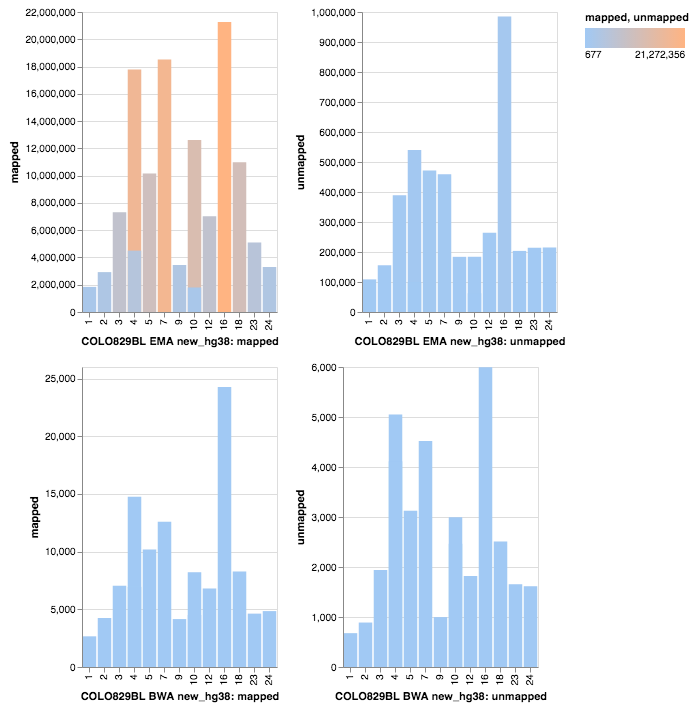

In [35]:
hg38_new_mapped_EMA = alt.Chart(colo829bl_elongated_EMA).mark_bar().encode(
        alt.X('chromosome:N', scale=alt.Scale(rangeStep=15), axis=alt.Axis(title='COLO829BL EMA new_hg38: mapped'), sort=chr_num),
        y = 'mapped:Q',
        color = alt.Color('mapped:Q', scale=alt.Scale(range=UMCCR_PALETTE)),
)

hg38_new_unmapped_EMA = alt.Chart(colo829bl_elongated_EMA).mark_bar().encode(
        alt.X('chromosome:N', scale=alt.Scale(rangeStep=15), axis=alt.Axis(title='COLO829BL EMA new_hg38: unmapped'), sort=chr_num),
        y = 'unmapped:Q',
        color = alt.Color('unmapped:Q', scale=alt.Scale(range=UMCCR_PALETTE)),
)

hg38_new_mapped_bwa = alt.Chart(colo829bl_elongated_bwa).mark_bar().encode(
        alt.X('chromosome:N', scale=alt.Scale(rangeStep=15), axis=alt.Axis(title='COLO829BL BWA new_hg38: mapped'), sort=chr_num),
        y = 'mapped:Q',
        color = alt.Color('mapped:Q', scale=alt.Scale(range=UMCCR_PALETTE)),
)

hg38_new_unmapped_bwa = alt.Chart(colo829bl_elongated_bwa).mark_bar().encode(
        alt.X('chromosome:N', scale=alt.Scale(rangeStep=15), axis=alt.Axis(title='COLO829BL BWA new_hg38: unmapped'), sort=chr_num),
        y = 'unmapped:Q',
        color = alt.Color('unmapped:Q', scale=alt.Scale(range=UMCCR_PALETTE)),
)


( hg38_new_mapped_EMA | hg38_new_unmapped_EMA ) & ( hg38_new_mapped_bwa | hg38_new_unmapped_bwa )

TODO:

1. ~~Plot hg38 vs hg38_new counts (as in "before vs after" comparison), by columns.~~
2. ~~Order by chromosome number (get rid of specific BED coordinates on the chr name (s/chr3:0-60000/chr3/))~~
3. ~~Keep forward/reverse columns in mind: infer from coordinates (i.e: chr1:0-60000 should be 'forward').~~
4. ~~Re-align COLO829BL with BWA against hg38_new, not only EMA.~~
5. Fill up the missing chroms (6,8, etc...) with 0 counts for consistent plots?
6. ~~Revisit new_hg38_elongator.py so that it elongates the N regions with known telomeric sequences, not just the last hexamer before the N boundary.~~
7. ~~Make sure only telomeric repeats are elongated, not other arbitrary sequences.~~
8. Revisit non-forward sections.